# 패션 의류 분류 경진대회
- https://dacon.io/competitions/open/235594/overview/description
- 패션 의류 분류

# 라이브러리

In [1]:
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import KFold , StratifiedKFold

In [2]:
def reset_seeds(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    print(f"RANDOM SEEDS RESET {seed}")  

# 구글 드라이브 연결

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 불러오기

- 데이터 경로

In [6]:
DATA_PATH = "/content/drive/MyDrive/DACON_이미지분류실습/data/"
SEED = 42

- 학습및 평가, 제출파일 데이터 불러오기

In [7]:
train = pd.read_csv(f'{DATA_PATH}train.csv')
test = pd.read_csv(f'{DATA_PATH}test.csv')
sample_submission = pd.read_csv(f'{DATA_PATH}sample_submission.csv')

train.shape , test.shape, sample_submission.shape

((60000, 786), (10000, 785), (10000, 2))

In [8]:
train.head()

,index,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,6,0,0,0,0,0,0,0,5,...,0,0,0,30,43,0,0,0,0,0
3,3,0,0,0,0,1,2,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,4,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
test.head()

,index,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
sample_submission.head()

,index,label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


# 전처리

- 이미지 데이터 shape으로 변경 

In [11]:
train_arr = train.iloc[:,2:].to_numpy().reshape(-1,28,28,1)
test_arr = test.iloc[:,1:].to_numpy().reshape(-1,28,28,1)
train_arr.shape , test_arr.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

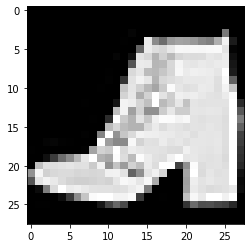

In [12]:
plt.imshow(train_arr[42].reshape(28,28),cmap='gray')
plt.show()

- 정답 데이터 

In [13]:
train["label"].nunique()

10

In [14]:
target = train["label"].to_numpy()
target

array([2, 9, 6, ..., 8, 8, 7])

- 스케일 조정

In [15]:
train_arr = train_arr / 255
test_arr = test_arr / 255

# 모델 정의

In [16]:
def build_model(optimizer = "adam",metrics = ['acc'] ):
    layer_list = [
        tf.keras.layers.Conv2D(16,5,input_shape=(28,28,1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Conv2D(32,5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Conv2D(64,5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1024,activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10,activation='softmax')
    ]
    model = tf.keras.Sequential(layer_list)
    model.compile(loss='sparse_categorical_crossentropy', optimizer = optimizer,metrics = metrics)
    return model

- 모델 구조 확인하기

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 16)        416       
                                                                 
 batch_normalization (BatchN  (None, 24, 24, 16)       64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 24, 24, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 32)        12832     
                                                                 
 batch_normalization_1 (Batc  (None, 20, 20, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 20, 20, 32)        0

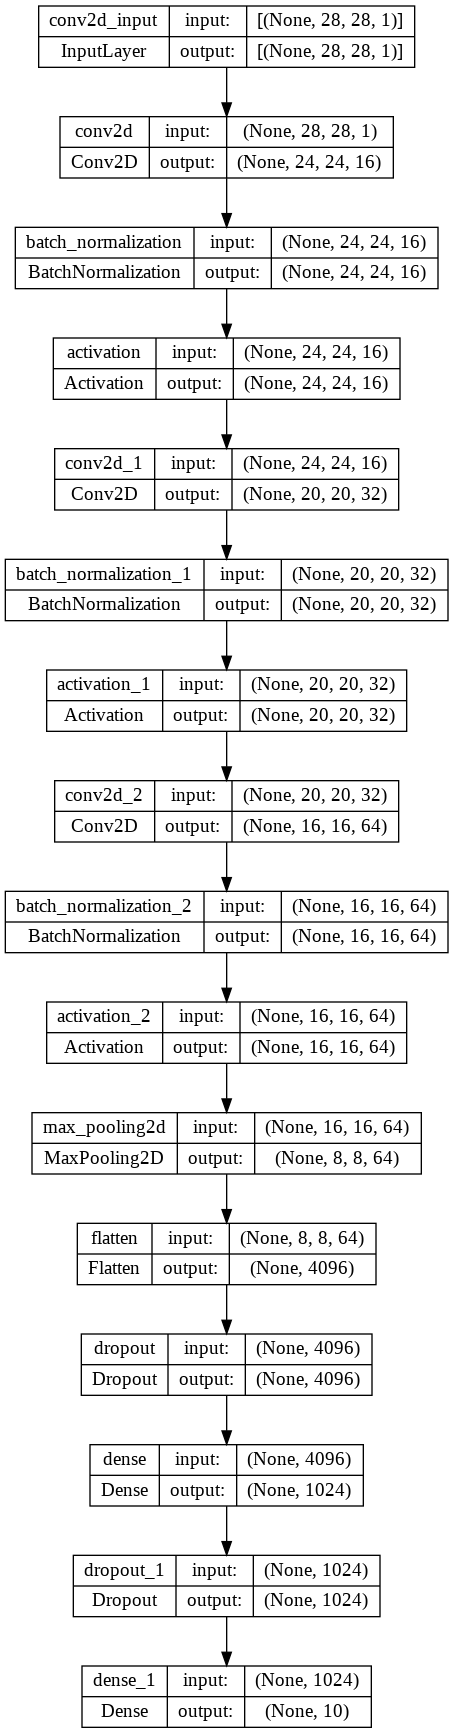

In [17]:
model = build_model()
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

# 학습하기

In [18]:
n_splits = 5
cv = StratifiedKFold(n_splits = n_splits, random_state = SEED, shuffle = True)

In [19]:
reset_seeds(SEED)
score_list = []
for i,(tri,vai) in enumerate(cv.split(train_arr, target)):
    es = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5,mode="max",restore_best_weights=True) # 조기 종료 조건을 주기 위한 객체
    model = build_model()
    history = model.fit(train_arr[tri],target[tri] , epochs=50, batch_size= 128,callbacks=[es], validation_data=(train_arr[vai],target[vai])
                        )
    
    score_list.append(max(history.history["val_acc"])) # 폴드별 최고 정확도 점수 저장
    model.save_weights(f"{i}_fold_model_weight.h5") # 폴드별 최고 점수 가중치 저장
print(score_list) # 폴드별 정확도 출력
print(np.mean(score_list)) # CV 평균 정확도 출력

RANDOM SEEDS RESET 42
Epoch 1/50
375/375 [==============================] - 13s 12ms/step - loss: 0.7319 - acc: 0.7590 - val_loss: 0.7036 - val_acc: 0.7613
Epoch 2/50
375/375 [==============================] - 4s 10ms/step - loss: 0.4279 - acc: 0.8417 - val_loss: 0.3495 - val_acc: 0.8665
Epoch 3/50
375/375 [==============================] - 4s 11ms/step - loss: 0.3727 - acc: 0.8633 - val_loss: 0.3311 - val_acc: 0.8804
Epoch 4/50
375/375 [==============================] - 4s 10ms/step - loss: 0.3347 - acc: 0.8771 - val_loss: 0.2878 - val_acc: 0.8920
Epoch 5/50
375/375 [==============================] - 4s 11ms/step - loss: 0.3124 - acc: 0.8855 - val_loss: 0.3041 - val_acc: 0.8888
Epoch 6/50
375/375 [==============================] - 4s 11ms/step - loss: 0.2941 - acc: 0.8910 - val_loss: 0.2724 - val_acc: 0.9017
Epoch 7/50
375/375 [==============================] - 4s 11ms/step - loss: 0.2780 - acc: 0.8976 - val_loss: 0.2645 - val_acc: 0.9039
Epoch 8/50
375/375 [==========================

# 추론하기

In [20]:
pred_list = []
for i in range(n_splits):
    model = build_model()
    model.load_weights(f"{i}_fold_model_weight.h5") # 저장된 모델 가중치 적용
    pred = model.predict(test_arr) # 추론
    pred_list.append(pred)

313/313 [==============================] - 1s 2ms/step


- 산술평균 앙상블

In [21]:
pred = np.mean(pred_list,axis=0)
pred = np.argmax(pred,axis=1)
pred

array([0, 1, 2, ..., 8, 8, 1])

In [22]:
sample_submission["label"] = pred
sample_submission

,index,label
0,0,0
1,1,1
2,2,2
3,3,6
4,4,3
...,...,...
9995,9995,0
9996,9996,6
9997,9997,8
9998,9998,8


In [23]:
sample_submission.to_csv('submit.csv', index = False)